---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [1]:
import sys, os

# spyder up to find the root
oceanbench_root = "/gpfswork/rech/cli/uvo53rl/projects/oceanbench"

# append to path
sys.path.append(str(oceanbench_root))

In [2]:
import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF


sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Processing Chain

**Part I**:

* Open Dataset
* Validate Coordinates + Variables
* Decode Time
* Select Region
* Sortby Time

**Part II**: Regrid

**Part III**:

* Interpolate Nans
* Add Units
* Spatial Rescale
* Time Rescale

**Part IV**: Metrics

*

## Data

In [3]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [4]:
# !cat configs/postprocess.yaml

In [5]:
# # load config
# config_dm = OmegaConf.load('./configs/postprocess.yaml')

# # instantiate
# ds = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D)
# ds

## Reference Dataset

For the reference dataset, we will look at the NEMO simulation of the Gulfstream.

In [6]:
%%time

# load config
config_dm = OmegaConf.load('./configs/postprocess.yaml')

# instantiate
ds_natl60 = hydra.utils.instantiate(config_dm.NATL60_GF_FULL).compute()
ds_natl60

CPU times: user 11.7 s, sys: 2.59 s, total: 14.3 s
Wall time: 18.8 s


<xarray.Dataset>
Dimensions:  (time: 42, lat: 600, lon: 600)
Coordinates:
  * lon      (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat      (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.6549 0.6571 0.6593 ... -0.2152 -0.2174
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

### Prediction Datasets - NADIR

In [7]:
%%time

# load config
results_config = OmegaConf.load('./configs/results_dc20a_nadir.yaml')

# instantiate
ds_duacs = hydra.utils.instantiate(results_config.DUACS_NADIR.data).compute()
ds_miost = hydra.utils.instantiate(results_config.MIOST_NADIR.data).compute()
ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_NADIR.data).compute()
ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_NADIR.data).compute()
ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_NADIR.data).compute()

CPU times: user 168 ms, sys: 60 ms, total: 228 ms
Wall time: 276 ms


## Regrdding

In [8]:
from oceanbench._src.geoprocessing.gridding import grid_to_regular_grid


In [9]:
%%time

ds_duacs = grid_to_regular_grid(
    src_grid_ds=ds_duacs.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_miost = grid_to_regular_grid(
    src_grid_ds=ds_miost.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_siren = grid_to_regular_grid(
    src_grid_ds=ds_nerf_siren.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_ffn = grid_to_regular_grid(
    src_grid_ds=ds_nerf_ffn.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_mlp = grid_to_regular_grid(
    src_grid_ds=ds_nerf_mlp.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)

CPU times: user 48.5 s, sys: 980 ms, total: 49.4 s
Wall time: 49.6 s


### Preprocess Chain

In [10]:
%%time

# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_natl60 = hydra.utils.instantiate(psd_config.psd_preprocess_chain)(ds_natl60.pint.dequantify())
ds_duacs = hydra.utils.instantiate(psd_config.psd_preprocess_chain)(ds_duacs.pint.dequantify())
ds_miost = hydra.utils.instantiate(psd_config.psd_preprocess_chain)(ds_miost.pint.dequantify())
ds_nerf_siren = hydra.utils.instantiate(psd_config.psd_preprocess_chain)(ds_nerf_siren.pint.dequantify())
ds_nerf_ffn = hydra.utils.instantiate(psd_config.psd_preprocess_chain)(ds_nerf_ffn.pint.dequantify())
ds_nerf_mlp = hydra.utils.instantiate(psd_config.psd_preprocess_chain)(ds_nerf_mlp.pint.dequantify())


CPU times: user 19.8 s, sys: 76.2 ms, total: 19.9 s
Wall time: 20 s


## Power Spectrum (Isotropic)

In [11]:
%%time

# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_natl60_psd = hydra.utils.instantiate(psd_config.psd_isotropic_chain)(ds_natl60.pint.dequantify())
ds_duacs_psd = hydra.utils.instantiate(psd_config.psd_isotropic_chain)(ds_duacs.pint.dequantify())
ds_miost_psd = hydra.utils.instantiate(psd_config.psd_isotropic_chain)(ds_miost.pint.dequantify())
ds_nerf_siren_psd = hydra.utils.instantiate(psd_config.psd_isotropic_chain)(ds_nerf_siren.pint.dequantify())
ds_nerf_ffn_psd = hydra.utils.instantiate(psd_config.psd_isotropic_chain)(ds_nerf_ffn.pint.dequantify())
ds_nerf_mlp_psd = hydra.utils.instantiate(psd_config.psd_isotropic_chain)(ds_nerf_mlp.pint.dequantify())


CPU times: user 6.99 s, sys: 2.2 s, total: 9.19 s
Wall time: 9.42 s


In [12]:
from jejeqx._src.viz.xarray.psd import PlotPSDIsotropic, PlotPSDScoreIsotropic

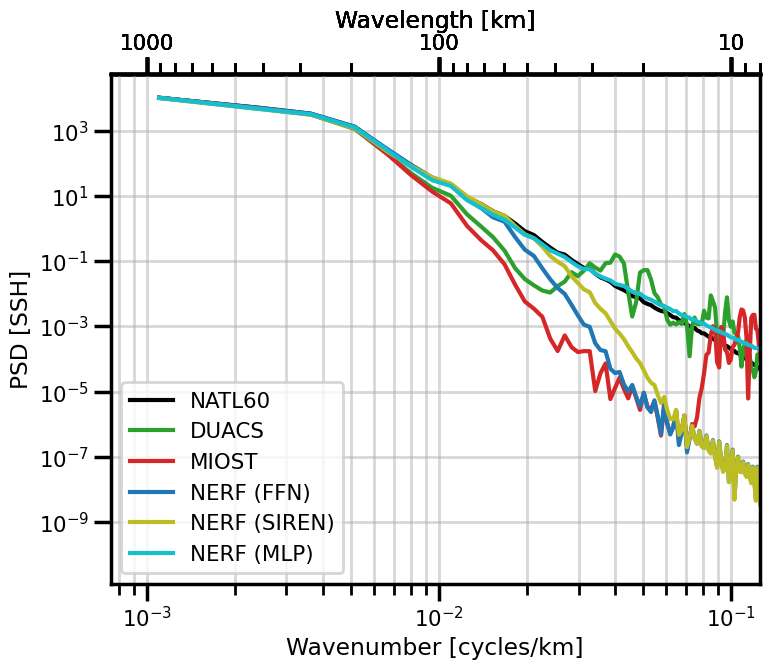

In [15]:
psd_iso_plot = PlotPSDIsotropic()
psd_iso_plot.init_fig(figsize=(8,7))
psd_iso_plot.plot_both(
    ds_natl60_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="NATL60",
    color="black",
)
psd_iso_plot.plot_both(
    ds_duacs_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="DUACS",
    color="tab:green",
)
psd_iso_plot.plot_both(
    ds_miost_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="MIOST",
    color="tab:red",
)
psd_iso_plot.plot_both(
    ds_nerf_ffn_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="NERF (FFN)",
    color="tab:blue",
)
psd_iso_plot.plot_both(
    ds_nerf_siren_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="NERF (SIREN)",
    color="tab:olive",
)
psd_iso_plot.plot_both(
    ds_nerf_mlp_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="NERF (MLP)",
    color="tab:cyan",
)

# set custom bounds
psd_iso_plot.ax.set_xlim((10**(-3) - 0.00025, 10**(-1) +0.025))
psd_iso_plot.ax.set_ylabel("PSD [SSH]")
plt.tight_layout()
plt.gcf().savefig("./figures/dc20a/psd/isotropic/dc20a_psd_isotropic_nadir.png")
plt.show()

### PSD Isotropic Score

In [16]:
%%time

# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_psd_duacs_score = hydra.utils.instantiate(
    psd_config.psd_isotropic_score, 
    da=ds_duacs.pint.dequantify(), 
    da_ref=ds_natl60.pint.dequantify()
)

ds_psd_miost_score = hydra.utils.instantiate(
    psd_config.psd_isotropic_score, 
    da=ds_miost.pint.dequantify(), 
    da_ref=ds_natl60.pint.dequantify()
)

ds_psd_nerf_mlp_score = hydra.utils.instantiate(
    psd_config.psd_isotropic_score, 
    da=ds_nerf_mlp.pint.dequantify(), 
    da_ref=ds_natl60.pint.dequantify()
)

ds_psd_nerf_ffn_score = hydra.utils.instantiate(
    psd_config.psd_isotropic_score, 
    da=ds_nerf_ffn.pint.dequantify(), 
    da_ref=ds_natl60.pint.dequantify()
)

ds_psd_nerf_siren_score = hydra.utils.instantiate(
    psd_config.psd_isotropic_score, 
    da=ds_nerf_siren.pint.dequantify(), 
    da_ref=ds_natl60.pint.dequantify()
)

CPU times: user 10.7 s, sys: 3.58 s, total: 14.2 s
Wall time: 14.3 s


In [17]:
from oceanbench._src.metrics.utils import find_intercept_1D, find_intercept_2D

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


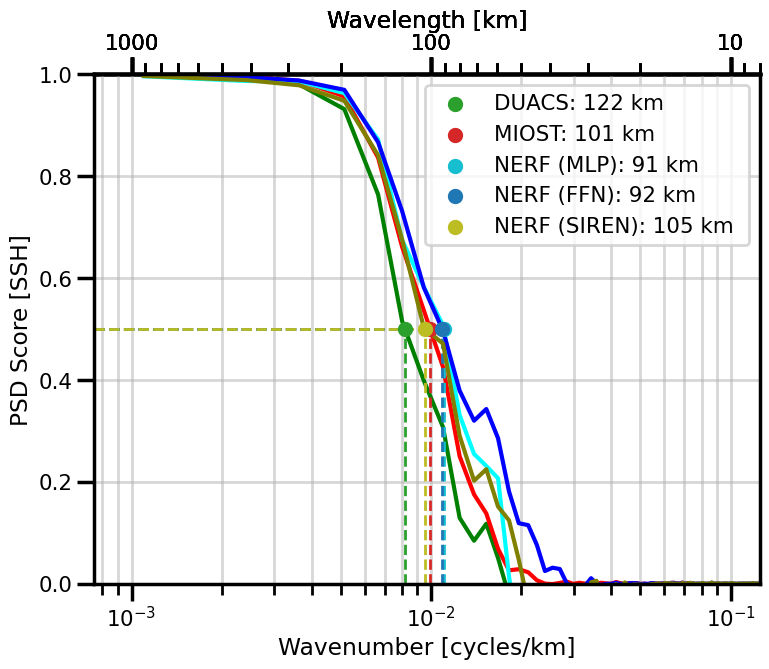

In [18]:
psd_iso_plot = PlotPSDScoreIsotropic()
psd_iso_plot.init_fig(figsize=(8,7))
psd_iso_plot.plot_score(
    ds_psd_duacs_score.ssh,
    freq_scale=1e3, 
    units="km",
    name="DUACS",
    color="green",
    threshhold=0.50,
    threshhold_color="tab:green"
    
)
psd_iso_plot.plot_score(
    ds_psd_miost_score.ssh,
    freq_scale=1e3, 
    units="km",
    name="MIOST",
    color="red",
    threshhold=0.50,
    threshhold_color="tab:red"
    
)
psd_iso_plot.plot_score(
    ds_psd_nerf_mlp_score.ssh,
    freq_scale=1e3, 
    units="km",
    name="NERF (MLP)",
    color="cyan",
    threshhold=0.50,
    threshhold_color="tab:cyan"
    
)
psd_iso_plot.plot_score(
    ds_psd_nerf_ffn_score.ssh,
    freq_scale=1e3, 
    units="km",
    name="NERF (FFN)",
    color="blue",
    threshhold=0.50,
    threshhold_color="tab:blue"
    
)
psd_iso_plot.plot_score(
    ds_psd_nerf_siren_score.ssh,
    freq_scale=1e3, 
    units="km",
    name="NERF (SIREN)",
    color="olive",
    threshhold=0.50,
    threshhold_color="tab:olive"
    
)

# set custom bounds
# psd_iso_plot.ax.set_xlim((10**(-3) - 0.00025, 10**(-1) +0.025))
psd_iso_plot.ax.set_ylabel("PSD Score [SSH]")
plt.legend()
plt.tight_layout()
plt.gcf().savefig("./figures/dc20a/psd_score/isotropic/dc20a_psd_isotropic_score_nadir.png")
plt.show()

## Prediction Datasets - SWOT

In [19]:
%%time

# load config
config_dm = OmegaConf.load('./configs/postprocess.yaml')

# instantiate
ds_natl60 = hydra.utils.instantiate(config_dm.NATL60_GF_FULL).compute()
ds_natl60

CPU times: user 11.5 s, sys: 2.4 s, total: 13.9 s
Wall time: 21.8 s


<xarray.Dataset>
Dimensions:  (time: 42, lat: 600, lon: 600)
Coordinates:
  * lon      (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat      (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.6549 0.6571 0.6593 ... -0.2152 -0.2174
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

In [20]:
%%time

# load config
results_config = OmegaConf.load('./configs/results_dc20a_swot.yaml')

# instantiate
ds_duacs = hydra.utils.instantiate(results_config.DUACS_SWOT.data).compute()
ds_miost = hydra.utils.instantiate(results_config.MIOST_SWOT.data).compute()
ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_SWOT.data).compute()
ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_SWOT.data).compute()
ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_SWOT.data).compute()

CPU times: user 166 ms, sys: 43.8 ms, total: 210 ms
Wall time: 490 ms


## Regrdding

In [21]:
from oceanbench._src.geoprocessing.gridding import grid_to_regular_grid


In [22]:
%%time

ds_duacs = grid_to_regular_grid(
    src_grid_ds=ds_duacs.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_miost = grid_to_regular_grid(
    src_grid_ds=ds_miost.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_siren = grid_to_regular_grid(
    src_grid_ds=ds_nerf_siren.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_ffn = grid_to_regular_grid(
    src_grid_ds=ds_nerf_ffn.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_mlp = grid_to_regular_grid(
    src_grid_ds=ds_nerf_mlp.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)

CPU times: user 48.8 s, sys: 819 ms, total: 49.6 s
Wall time: 49.7 s


### Preprocess Chain

In [23]:
%%time

# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_natl60 = hydra.utils.instantiate(psd_config.psd_preprocess_chain)(ds_natl60.pint.dequantify())
ds_duacs = hydra.utils.instantiate(psd_config.psd_preprocess_chain)(ds_duacs.pint.dequantify())
ds_miost = hydra.utils.instantiate(psd_config.psd_preprocess_chain)(ds_miost.pint.dequantify())
ds_nerf_siren = hydra.utils.instantiate(psd_config.psd_preprocess_chain)(ds_nerf_siren.pint.dequantify())
ds_nerf_ffn = hydra.utils.instantiate(psd_config.psd_preprocess_chain)(ds_nerf_ffn.pint.dequantify())
ds_nerf_mlp = hydra.utils.instantiate(psd_config.psd_preprocess_chain)(ds_nerf_mlp.pint.dequantify())


CPU times: user 19.8 s, sys: 85.8 ms, total: 19.9 s
Wall time: 20 s


## Power Spectrum (Isotropic)

In [24]:
%%time

# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_natl60_psd = hydra.utils.instantiate(psd_config.psd_isotropic_chain)(ds_natl60.pint.dequantify())
ds_duacs_psd = hydra.utils.instantiate(psd_config.psd_isotropic_chain)(ds_duacs.pint.dequantify())
ds_miost_psd = hydra.utils.instantiate(psd_config.psd_isotropic_chain)(ds_miost.pint.dequantify())
ds_nerf_siren_psd = hydra.utils.instantiate(psd_config.psd_isotropic_chain)(ds_nerf_siren.pint.dequantify())
ds_nerf_ffn_psd = hydra.utils.instantiate(psd_config.psd_isotropic_chain)(ds_nerf_ffn.pint.dequantify())
ds_nerf_mlp_psd = hydra.utils.instantiate(psd_config.psd_isotropic_chain)(ds_nerf_mlp.pint.dequantify())


CPU times: user 6.32 s, sys: 2.26 s, total: 8.58 s
Wall time: 8.61 s


In [25]:
from jejeqx._src.viz.xarray.psd import PlotPSDIsotropic, PlotPSDScoreIsotropic

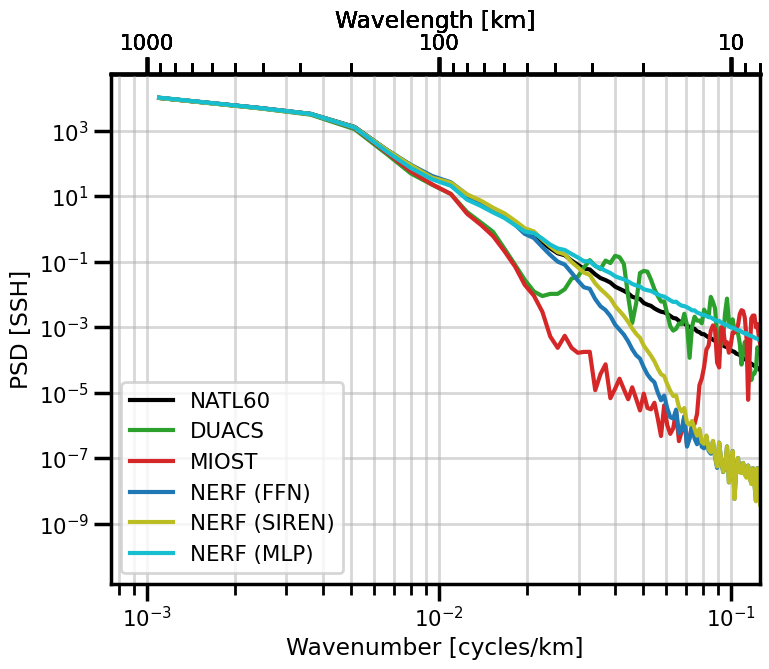

In [26]:
psd_iso_plot = PlotPSDIsotropic()
psd_iso_plot.init_fig(figsize=(8,7))
psd_iso_plot.plot_both(
    ds_natl60_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="NATL60",
    color="black",
)
psd_iso_plot.plot_both(
    ds_duacs_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="DUACS",
    color="tab:green",
)
psd_iso_plot.plot_both(
    ds_miost_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="MIOST",
    color="tab:red",
)
psd_iso_plot.plot_both(
    ds_nerf_ffn_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="NERF (FFN)",
    color="tab:blue",
)
psd_iso_plot.plot_both(
    ds_nerf_siren_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="NERF (SIREN)",
    color="tab:olive",
)
psd_iso_plot.plot_both(
    ds_nerf_mlp_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="NERF (MLP)",
    color="tab:cyan",
)

# set custom bounds
psd_iso_plot.ax.set_xlim((10**(-3) - 0.00025, 10**(-1) +0.025))
psd_iso_plot.ax.set_ylabel("PSD [SSH]")
plt.tight_layout()
plt.gcf().savefig("./figures/dc20a/psd/isotropic/dc20a_psd_isotropic_swot.png")
plt.show()

### PSD Isotropic Score

In [27]:
%%time

# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_psd_duacs_score = hydra.utils.instantiate(
    psd_config.psd_isotropic_score, 
    da=ds_duacs.pint.dequantify(), 
    da_ref=ds_natl60.pint.dequantify()
)

ds_psd_miost_score = hydra.utils.instantiate(
    psd_config.psd_isotropic_score, 
    da=ds_miost.pint.dequantify(), 
    da_ref=ds_natl60.pint.dequantify()
)

ds_psd_nerf_mlp_score = hydra.utils.instantiate(
    psd_config.psd_isotropic_score, 
    da=ds_nerf_mlp.pint.dequantify(), 
    da_ref=ds_natl60.pint.dequantify()
)

ds_psd_nerf_ffn_score = hydra.utils.instantiate(
    psd_config.psd_isotropic_score, 
    da=ds_nerf_ffn.pint.dequantify(), 
    da_ref=ds_natl60.pint.dequantify()
)

ds_psd_nerf_siren_score = hydra.utils.instantiate(
    psd_config.psd_isotropic_score, 
    da=ds_nerf_siren.pint.dequantify(), 
    da_ref=ds_natl60.pint.dequantify()
)

CPU times: user 10.6 s, sys: 3.56 s, total: 14.1 s
Wall time: 14.2 s


In [28]:
from oceanbench._src.metrics.utils import find_intercept_1D, find_intercept_2D

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


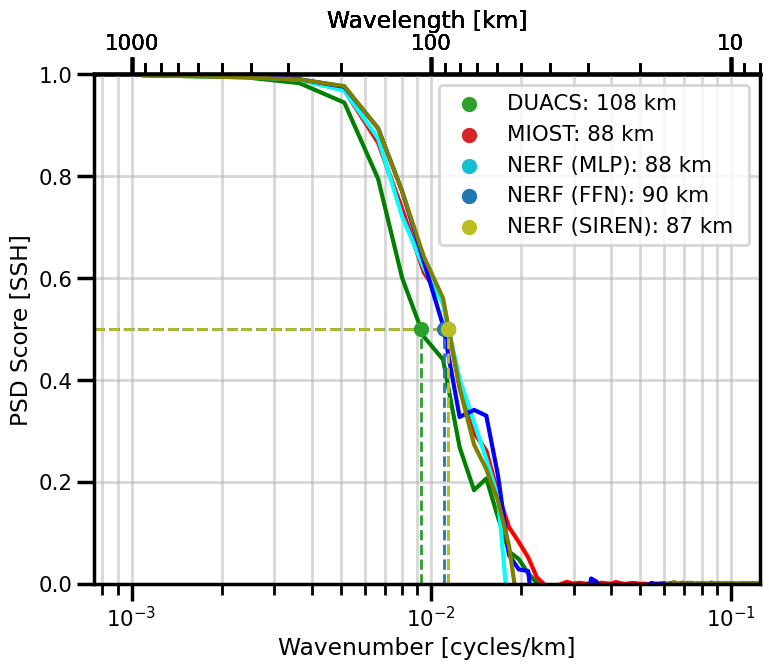

In [29]:
psd_iso_plot = PlotPSDScoreIsotropic()
psd_iso_plot.init_fig(figsize=(8,7))
psd_iso_plot.plot_score(
    ds_psd_duacs_score.ssh,
    freq_scale=1e3, 
    units="km",
    name="DUACS",
    color="green",
    threshhold=0.50,
    threshhold_color="tab:green"
    
)
psd_iso_plot.plot_score(
    ds_psd_miost_score.ssh,
    freq_scale=1e3, 
    units="km",
    name="MIOST",
    color="red",
    threshhold=0.50,
    threshhold_color="tab:red"
    
)
psd_iso_plot.plot_score(
    ds_psd_nerf_mlp_score.ssh,
    freq_scale=1e3, 
    units="km",
    name="NERF (MLP)",
    color="cyan",
    threshhold=0.50,
    threshhold_color="tab:cyan"
    
)
psd_iso_plot.plot_score(
    ds_psd_nerf_ffn_score.ssh,
    freq_scale=1e3, 
    units="km",
    name="NERF (FFN)",
    color="blue",
    threshhold=0.50,
    threshhold_color="tab:blue"
    
)
psd_iso_plot.plot_score(
    ds_psd_nerf_siren_score.ssh,
    freq_scale=1e3, 
    units="km",
    name="NERF (SIREN)",
    color="olive",
    threshhold=0.50,
    threshhold_color="tab:olive"
    
)

# set custom bounds
# psd_iso_plot.ax.set_xlim((10**(-3) - 0.00025, 10**(-1) +0.025))
psd_iso_plot.ax.set_ylabel("PSD Score [SSH]")
plt.legend()
plt.tight_layout()
plt.gcf().savefig("./figures/dc20a/psd_score/isotropic/dc20a_psd_isotropic_score_swot.png")
plt.show()